In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# set up training set
#view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_imp_fatal_cvd_patched_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
##########################################################
# make balanced data
##########################################################
#balanced_ids_train = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_ids_train.feather")
#view_1hot_df = view_1hot_df[view_1hot_df["VSIMPLE_INDEX_MASTER"].isin\
#                            (balanced_ids_train["VSIMPLE_INDEX_MASTER"])]
##########################################################
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

# set up test set
#test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
test_df = feather.read_dataframe("/home/whsu014/data/test_imp_fatal_cvd_patched_10096inds.feather")
print(test_df.columns)
print(test_df.shape)
print("Number of inds:", len(test_df['VSIMPLE_INDEX_MASTER'].unique()))
##########################################################
# make balanced data
##########################################################
#balanced_ids_test = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_ids_test.feather")
#test_df = test_df[test_df["VSIMPLE_INDEX_MASTER"].isin\
#                 (balanced_ids_test["VSIMPLE_INDEX_MASTER"])]
##########################################################
test_v = copy.deepcopy(test_df.iloc[:, :-7].values)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)
Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0
Index(['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2',
       'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=189)
(282688, 189)
Number of inds: 10096


In [3]:
print("Unique ids in balanced train set:", len(np.unique(train_v[:, 0])))
print("Unique ids in balanced test set:", len(np.unique(test_v[:, 0])))

Unique ids in balanced train set: 90000
Unique ids in balanced test set: 10096


In [4]:
print("Number of days:", view_1hot_df.columns.get_loc('NUMBER_OF_DAYS'))
print("Acute adm:", view_1hot_df.columns.get_loc('ACUTE_ADM'))
print("Mortality broad cvd with other:", view_1hot_df.columns.get_loc('mortality_broad_cvd_with_other'))
print("out broad_cvd:", view_1hot_df.columns.get_loc('out_broad_cvd'))
print("out atrial fibrillation:", view_1hot_df.columns.get_loc('out_atrial_fibrillation'))
print("PT IMP FATAL CVD:", view_1hot_df.columns.get_loc('PT_IMP_FATAL_CVD'))

Number of days: 120
Acute adm: 121
Mortality broad cvd with other: 143
out broad_cvd: 145
out atrial fibrillation: 162
PT IMP FATAL CVD: 181


In [5]:
print('AGE:', view_1hot_df.columns.get_loc('AGE'))
print('NZDEP:', view_1hot_df.columns.get_loc('NZDEP'))
print('ETHN_1:', view_1hot_df.columns.get_loc('ETHN_1'))
print('ETHN_5:', view_1hot_df.columns.get_loc('ETHN_5'))
print('TEST:', view_1hot_df.columns.get_loc('TEST'))
print('HDL:', view_1hot_df.columns.get_loc('HDL'))
print('LDL:', view_1hot_df.columns.get_loc('LDL'))
print('TRI:', view_1hot_df.columns.get_loc('TRI'))
print('TCL:', view_1hot_df.columns.get_loc('TCL'))
print('TCHDL:', view_1hot_df.columns.get_loc('TCHDL'))
print('TESTED:', view_1hot_df.columns.get_loc('TESTED'))
print('DIED:', view_1hot_df.columns.get_loc('DIED'))
print('############# PHARMS ##############')
print('LL_SIMVASTATIN:', view_1hot_df.columns.get_loc('LL_SIMVASTATIN'))
print('LL_PDC:', view_1hot_df.columns.get_loc('LL_PDC'))
print('CVD_FELODIPINE:', view_1hot_df.columns.get_loc('CVD_FELODIPINE'))
print('CVD_HYDROCHLOROTHIAZIDE:', view_1hot_df.columns.get_loc('CVD_HYDROCHLOROTHIAZIDE'))
print('OTHER_TENOXICAM:', view_1hot_df.columns.get_loc('OTHER_TENOXICAM'))
print('OTHER_VILDAGLIPTIN:', view_1hot_df.columns.get_loc('OTHER_VILDAGLIPTIN'))
print('############# NMDS ##############')
print('NUMBER_OF_DAYS:', view_1hot_df.columns.get_loc('NUMBER_OF_DAYS'))
print('hx_broad_cvd:', view_1hot_df.columns.get_loc('hx_broad_cvd'))
print('out_atrial_fibrillation:', view_1hot_df.columns.get_loc('out_atrial_fibrillation'))
print('############# HbA1c, GFR and PT ##############')
print('HBA1C:', view_1hot_df.columns.get_loc('HBA1C'))
print('TEST_HBA1C:', view_1hot_df.columns.get_loc('TEST_HBA1C'))
print('TESTED_HBA1c:', view_1hot_df.columns.get_loc('TESTED_HBA1C'))
print('EGFR:', view_1hot_df.columns.get_loc('EGFR'))
print('TEST_EGFR:',view_1hot_df.columns.get_loc('TEST_EGFR'))
print('TESTED_EGFR:', view_1hot_df.columns.get_loc('TESTED_EGFR'))
print('PT_SBP:', view_1hot_df.columns.get_loc('PT_SBP'))
print('PT_DIABETES_YR:', view_1hot_df.columns.get_loc('PT_DIABETES_YR'))
print('PT_ATRIAL_FIBRILLATION:', view_1hot_df.columns.get_loc('PT_ATRIAL_FIBRILLATION'))
print('PT_IMP_FATAL_CVD:', view_1hot_df.columns.get_loc('PT_IMP_FATAL_CVD'))

AGE: 1
NZDEP: 3
ETHN_1: 4
ETHN_5: 8
TEST: 9
HDL: 10
LDL: 11
TRI: 12
TCL: 13
TCHDL: 14
TESTED: 15
DIED: 16
############# PHARMS ##############
LL_SIMVASTATIN: 17
LL_PDC: 28
CVD_FELODIPINE: 29
CVD_HYDROCHLOROTHIAZIDE: 81
OTHER_TENOXICAM: 82
OTHER_VILDAGLIPTIN: 119
############# NMDS ##############
NUMBER_OF_DAYS: 120
hx_broad_cvd: 122
out_atrial_fibrillation: 162
############# HbA1c, GFR and PT ##############
HBA1C: 163
TEST_HBA1C: 164
TESTED_HBA1c: 165
EGFR: 166
TEST_EGFR: 167
TESTED_EGFR: 168
PT_SBP: 169
PT_DIABETES_YR: 179
PT_ATRIAL_FIBRILLATION: 180
PT_IMP_FATAL_CVD: 181


In [6]:
print(list(view_1hot_df.columns))

['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'TESTED', 'DIED', 'LL_SIMVASTATIN', 'LL_BEZAFIBRATE', 'LL_ATORVASTATIN', 'LL_EZETIMIBE', 'LL_NICOTINIC_ACID', 'LL_ACIPIMOX', 'LL_CHOLESTYRAMINE', 'LL_COLESTIPOL_HYDROCHLORIDE', 'LL_PRAVASTATIN', 'LL_EZETIMIBE_WITH_SIMVASTATIN', 'LL_GEMFIBROZIL', 'LL_PDC', 'CVD_FELODIPINE', 'CVD_QUINAPRIL', 'CVD_METOPROLOL_SUCCINATE', 'CVD_CILAZAPRIL', 'CVD_ATENOLOL', 'CVD_BENDROFLUMETHIAZIDE', 'CVD_WARFARIN_SODIUM', 'CVD_FUROSEMIDE', 'CVD_CELIPROLOL', 'CVD_DILTIAZEM_HYDROCHLORIDE', 'CVD_ASPIRIN', 'CVD_NIFEDIPINE', 'CVD_CAPTOPRIL', 'CVD_DIPYRIDAMOLE', 'CVD_CANDESARTAN_CILEXETIL', 'CVD_INDAPAMIDE', 'CVD_ENALAPRIL_MALEATE', 'CVD_SOTALOL', 'CVD_GLYCERYL_TRINITRATE', 'CVD_ISOSORBIDE_MONONITRATE', 'CVD_PINDOLOL', 'CVD_CARVEDILOL', 'CVD_METHYLDOPA', 'CVD_LOSARTAN_POTASSIUM', 'CVD_VERAPAMIL_HYDROCHLORIDE', 'CVD_AMILORIDE_HYDROCHLORIDE', 'CVD_CLONIDINE_HYDROCHLORIDE', 'C

In [9]:
def setup_xy_last_quarter(time_series_v):
    num_of_inds = time_series_v.shape[0]//28
    num_of_features = time_series_v.shape[1]
    
    x_ = np.empty((num_of_inds, num_of_features))
    y_ = []
    for i in range(num_of_inds):
        ind_v = copy.deepcopy(time_series_v[(i*28):((i+1)*28), :])
        x_[i, :] = ind_v[7, :]
        ###########################
        # construct y
        ###########################
        event = False
        for j in range(8, 28):
            if ind_v[j, 121] == 1.0 and \
                1.0 in ind_v[j, 143:162]: # an acute CVD event
                event = True
        if 1.0 in ind_v[8:, 181]: # a CVD death
            event = True
        if event:
            y_.append(1)
        else:
            y_.append(0)
    return x_, np.array(y_)

In [10]:
def setup_xy_aggregated(time_series_v):
    num_of_inds = time_series_v.shape[0]//28
    num_of_features = time_series_v.shape[1]
    
    x_ = np.empty((num_of_inds, num_of_features))
    y_ = []
    for i in range(num_of_inds):
        ind_v = copy.deepcopy(time_series_v[(i*28):((i+1)*28), :])
        x_[i, 0:9] = ind_v[7, 0:9]
        x_[i, 9:169] = np.sum(ind_v[:8, 9:169], axis=0)/8.0
        x_[i, 169:182] = ind_v[7, 169:182]
        ###########################
        # construct y
        ###########################
        event = False
        for j in range(8, 28):
            if ind_v[j, 121] == 1.0 and \
                1.0 in ind_v[j, 143:162]: # an acute CVD event
                event = True
        if 1.0 in ind_v[8:, 181]:  # a CVD death
            event = True
        if event:
            y_.append(1)
        else:
            y_.append(0)
    return x_, np.array(y_)

In [11]:
def setup_xy(time_series_v):
    x_ = []
    y_ = []
    num_of_inds = time_series_v.shape[0]//28
    num_of_features = time_series_v.shape[1]
    print("Number of inds:", num_of_inds)
    print("Number of features:", num_of_features)
    for i in range(num_of_inds):
        ind_v = time_series_v[(i*28):((i+1)*28), :]
        ind_x = ind_v[:8, :] 
        ind_flat_x = []
        for j in range(len(ind_x)):
            if j == 0:
                ind_flat_x.extend(ind_x[j, :])
            else:
                ind_flat_x.extend(ind_x[j, 1:])
        x_.append(np.array(ind_flat_x))
        ###########################
        # construct y
        ###########################
        event = False
        for j in range(8, 28):
            if ind_v[j, 121] == 1.0 and \
                1.0 in ind_v[j, 143:162]: # an acute CVD event
                event = True
        if 1.0 in ind_v[8:, 181]: # a CVD death
            event = True
        if event:
            y_.append(1)
        else:
            y_.append(0)
    return np.array(x_), np.array(y_)

In [55]:
#x_train, y_train = setup_xy(train_v)
#x_test, y_test = setup_xy(test_v)

#x_train, y_train = setup_xy_aggregated(train_v)
#x_test, y_test = setup_xy_aggregated(test_v)

x_train, y_train = setup_xy_last_quarter(train_v)
x_test, y_test = setup_xy_last_quarter(test_v)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(np.count_nonzero(y_train==1))
print(np.count_nonzero(y_test==1))
#print(y_train[y_train==1].shape)
#print(y_test[y_test==1].shape)

(90000, 182)
(90000,)
(10096, 182)
(10096,)
10945
1286


In [56]:
# For Logistic Regression
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)
x_train = scaled_train
x_test = scaled_test

In [11]:
print(y_train[:100])
print(y_test[:100])
print(y_train.shape)
print(y_train[y_train[:] == 0].shape)
print(y_train[y_train[:] == 1].shape)
print()
print(y_test.shape)
print(y_test[y_test[:] == 0].shape)
print(y_test[y_test[:] == 1].shape)

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
[1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(90000,)
(78528,)
(11472,)

(10096,)
(8739,)
(1357,)


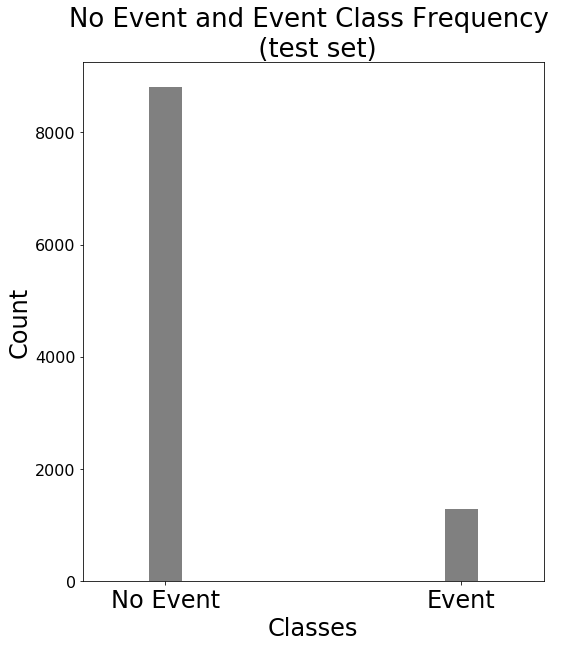

In [15]:
pyplot.rcParams.update({'font.size':16})
pyplot.figure(figsize=(8,9))

fs= 20
pyplot.subplot(111)
pyplot.hist(y_test[:], bins=10, color='gray')

pyplot.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.90, hspace=0.4, wspace=0.2)

pyplot.xlim(-0.2, 1.2)
pyplot.xticks([0.05, 0.95], ["No Event", "Event"], fontsize=fs*1.2)
pyplot.title('No Event and Event Class Frequency \n (test set)', fontsize=fs*1.3)
pyplot.xlabel('Classes', fontsize=fs*1.2)
pyplot.ylabel('Count', fontsize=fs*1.2)
#pyplot.legend(fontsize=fs*0.8, loc='lower right')
filename = "/home/whsu014/plots/EVENT_class_frequency_test_I.png"
#pyplot.savefig(filename, bbox_inches='tight')
pyplot.show()

In [57]:
num_of_inds = x_train.shape[0]
num_per_fold = num_of_inds//10
print("Number of inds:", num_of_inds)
print("Number per fold:", num_per_fold)

start_time = time.time()
for f in range(1):
    #start = f*num_per_fold
    end = (f+1)*num_per_fold
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_lr = np.append(train2_x, train1_x, axis=0) #new obj
    train1_y = y_train[:end, ]
    train2_y = y_train[end:, ]
    train_y_lr = np.append(train2_y, train1_y, axis=0)
    print("train_x_lr:", train_x_lr.shape)
    print("train_y_lr:", train_y_lr.shape)
    
    # remove data used for 
    # validation set
    
    val_num = int(np.ceil(train_x_lr.shape[0]/10))
    print("val num:", val_num)
    train_x = train_x_lr[:-val_num, :]
    print("Train x shape:", train_x.shape)
    train_y = train_y_lr[:-val_num]
    print("Train y shape:", train_y.shape)
    
    val_x = train_x_lr[-val_num:, :]
    val_y = train_y_lr[-val_num:]
    print("Val x shape:", val_x.shape)
    print("Val y shape:", val_y.shape)

    ###########################
    # RidgeClassifier
    ###########################
    '''
    rcv = RidgeClassifierCV(alphas=[1e-6, 1e-5, 1e-4, 
                          1e-3, 1e-2, 1e-1,
                          1.0, 10.0], 
                          normalize=True,
                          class_weight='balanced',
                          store_cv_values=True).fit(train_x, train_y)

    print("Prediction using RidgeCV")
    a = rcv.alpha_
    print("Alpha:", a)
    print("Mean accuracy:", rcv.score(val_x, val_y))
    '''
    ###########################
    # LogisticRegression
    ###########################
    
    rcv = LogisticRegression(solver='lbfgs',
                            penalty='none',
                            #max_iter=10000,
                            class_weight='balanced'
                            ).fit(train_x, train_y)
    print("Mean accuracy:", rcv.score(val_x, val_y))
    
    ########################
    # Predict on test set
    ########################
    print("Test x shape:", x_test.shape)
    print("Test y shape:", y_test.shape)
    test_yhat = rcv.predict(x_test)
    rc_probs = rcv.decision_function(x_test)
    print('Regression model probs shape:', rc_probs.shape)
    print(np.array([rc_probs[: ]]).T.shape)
    
print("Entire process took: ", time.time() - start_time)

Number of inds: 90000
Number per fold: 9000
train_x_lr: (90000, 182)
train_y_lr: (90000,)
val num: 9000
Train x shape: (81000, 182)
Train y shape: (81000,)
Val x shape: (9000, 182)
Val y shape: (9000,)
Mean accuracy: 0.7577777777777778
Test x shape: (10096, 182)
Test y shape: (10096,)
Regression model probs shape: (10096,)
(10096, 1)
Entire process took:  3.512629508972168


/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [58]:
rc_probs_df = pd.DataFrame(rc_probs)
rc_probs_df.columns = ['CVD_EVENT']
print(rc_probs_df.shape)
#feather.write_dataframe(rc_probs_df, "/home/whsu014/data/EVENT_RC_Class_weight_yhat.feather")
feather.write_dataframe(rc_probs_df, "/home/whsu014/data/EVENT_LR_L_Class_Weight_IFC_patched_yhat.feather")

(10096, 1)


In [108]:
y_test_df = pd.DataFrame(y_test)
print(y_test_df.shape)
y_test_df.columns = ['CVD_EVENT']
feather.write_dataframe(y_test_df, "/home/whsu014/data/EVENT_balanced_y_test.feather")

(2714, 1)


## Cox proportional hazard data preparation.
## Will Use Package 'survival' and 'pec' in R
## for Cox regression analysis.

In [62]:
def setup_xy_last_quarter_cox(time_series_v):
    num_of_inds = time_series_v.shape[0]//28
    num_of_features = time_series_v.shape[1]
    
    x_ = np.empty((num_of_inds, num_of_features + 1)) # additional feature time
    y_ = []
    for i in range(num_of_inds):
        ind_v = copy.deepcopy(time_series_v[(i*28):((i+1)*28), :])
        x_[i, :-1] = ind_v[7, :]
        ###########################
        # construct y
        ###########################
        event = False
        event_time = [90 * 20]
        for j in range(8, 28):
            if ind_v[j, 121] == 1.0 and \
                1.0 in ind_v[j, 143:162]: # an acute CVD event
                event = True
                event_time.append((j-7)*90)
            if 1.0 == ind_v[j, 181]: # a CVD death
                event = True
                event_time.append((j-7)*90)
        x_[i, -1] = min(event_time) # time to first event
        if event:
            y_.append(1)
        else:
            y_.append(0)
    return x_, np.array(y_)

In [63]:
def setup_xy_aggregated_cox(time_series_v):
    num_of_inds = time_series_v.shape[0]//28
    num_of_features = time_series_v.shape[1]
    
    x_ = np.empty((num_of_inds, num_of_features + 1)) # additional feature time
    y_ = []
    for i in range(num_of_inds):
        ind_v = copy.deepcopy(time_series_v[(i*28):((i+1)*28), :])
        x_[i, 0:9] = ind_v[7, 0:9]
        x_[i, 9:169] = np.sum(ind_v[:8, 9:169], axis=0)/8.0
        x_[i, 169:182] = ind_v[7, 169:182]
        ###########################
        # construct y
        ###########################
        event = False
        event_time = [90 * 20]
        for j in range(8, 28):
            if ind_v[j, 121] == 1.0 and \
                1.0 in ind_v[j, 143:162]:  # an acute CVD event
                event = True
                event_time.append((j-7)*90)
            if 1.0 == ind_v[j, 181]: # a CVD death
                event = True
                event_time.append((j-7)*90)
        x_[i, -1] = min(event_time) # time to first event
        if event:
            y_.append(1)
        else:
            y_.append(0)
    return x_, np.array(y_)

In [64]:
def setup_xy_cox(time_series_v):
    x_ = []
    y_ = []
    num_of_inds = time_series_v.shape[0]//28
    num_of_features = time_series_v.shape[1]
    print("Number of inds:", num_of_inds)
    print("Number of features:", num_of_features)
    for i in range(num_of_inds):
        ind_v = time_series_v[(i*28):((i+1)*28), :]
        ind_x = ind_v[:8, :] 
        ind_flat_x = []
        for j in range(len(ind_x)):
            if j == 0:
                ind_flat_x.extend(ind_x[j, :])
            else:
                ind_flat_x.extend(ind_x[j, 1:])
        ###########################
        # construct y
        ###########################
        event = False
        event_time = [90 * 20]
        for j in range(8, 28):
            if ind_v[j, 121] == 1.0 and \
                1.0 in ind_v[j, 143:162]: # an acute CVD event
                event = True
                event_time.append((j-7)*90)
            if 1.0 == ind_v[j, 181]: # a CVD death
                event = True
                event_time.append((j-7)*90)
        ind_flat_x.append(min(event_time)) # time to first event
        x_.append(np.array(ind_flat_x))
        if event:
            y_.append(1)
        else:
            y_.append(0)
    return np.array(x_), np.array(y_)

In [84]:
# dimensions are (row, (column + 1)): 1 being time to event 
#x_train, y_train = setup_xy_cox(train_v)
#x_test, y_test = setup_xy_cox(test_v)

#x_train, y_train = setup_xy_aggregated_cox(train_v)
#x_test, y_test = setup_xy_aggregated_cox(test_v)

x_train, y_train = setup_xy_last_quarter_cox(train_v)
x_test, y_test = setup_xy_last_quarter_cox(test_v)


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(np.count_nonzero(y_train))
print(np.count_nonzero(y_test))

(90000, 183)
(90000,)
(10096, 183)
(10096,)
10945
1286


In [69]:
print(y_test[:40])
print(x_test[:40, -2:])

[1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0]
[[   0. 1080.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1530.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0.  630.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0.  630.]
 [   0.  810.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]
 [   0. 1800.]]


In [16]:
# Don't scale time to event
'''
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train[:, :-1]) # don't scale time to event
scaled_test = scaler.transform(x_test[:, :-1])
x_train_scaled = np.append(scaled_train, 
                           np.array([x_train[:, -1]]).T, 
                           axis=1)
x_test_scaled = np.append(scaled_test, 
                          np.array([x_test[:, -1]]).T,
                          axis=1)
print(scaled_train.shape)
print(scaled_test.shape)
'''
# Scale time to event
'''
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(np.round(x_train_scaled[:5, :30], 
              decimals=2))
'''

(90000, 1448)
(10096, 1448)


'\nscaler = MinMaxScaler()\nx_train_scaled = scaler.fit_transform(x_train)\nx_test_scaled = scaler.transform(x_test)\nprint(x_train_scaled.shape)\nprint(x_test_scaled.shape)\nprint(np.round(x_train_scaled[:5, :30], \n              decimals=2))\n'

In [37]:
'''
train_cox_v = np.append(x_train_scaled, np.array([y_train]).T, axis = 1)
print(train_cox_v.shape)
test_cox_v = np.append(x_test_scaled, np.array([y_test]).T, axis = 1)
print(test_cox_v.shape)
'''

(90000, 184)
(10096, 184)


In [70]:
# generate long column name
col_names = list(test_df.columns)
col_names = col_names[:-7]

new_col_names = []
for i in range(8):
    for j in range(len(col_names)):
        if i == 0: # first row, include ID
            name = col_names[j] + "_" + str(i+1)
            new_col_names.append(name)
        else:
            if j > 0: # exclude ID
                name = col_names[j] + "_" + str(i+1)
                new_col_names.append(name)
new_col_names.extend(["TIME", "STATUS"])
print(len(new_col_names))

1451


In [85]:
# short column names
col_names = list(test_df.columns)
col_names = col_names[:-7]
print(len(col_names))
col_names.extend(["TIME", "STATUS"])
print(len(col_names))

182
184


In [86]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print()
train_cox_v = np.append(x_train, np.array([y_train]).T, axis = 1)
print(train_cox_v.shape)
test_cox_v = np.append(x_test, np.array([y_test]).T, axis = 1)
print(test_cox_v.shape)

(90000, 183)
(90000,)
(10096, 183)
(10096,)

(90000, 184)
(10096, 184)


In [87]:
train_cox_df = pd.DataFrame(train_cox_v)
test_cox_df = pd.DataFrame(test_cox_v)
train_cox_df.columns = col_names
test_cox_df.columns = col_names

feather.write_dataframe(train_cox_df, "/home/whsu014/data/Cox_EVENT_last_quarter_train.feather")
feather.write_dataframe(test_cox_df, "/home/whsu014/data/Cox_EVENT_last_quarter_test.feather")

## create a vector of sample weights

In [17]:
print(y_train.shape)
sample_weight=class_weight.compute_sample_weight("balanced",
                                                  y_train)
print(sample_weight.shape)
print(np.unique(sample_weight))
sample_weight_df = pd.DataFrame(sample_weight)
sample_weight_df.columns = ["SAMPLE_WEIGHT"]
feather.write_dataframe(sample_weight_df, "/home/whsu014/data/Cox_EVENT_train_sample_weights.feather")

(90000,)
(90000,)
[0.57304401 3.92259414]


In [46]:
train_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_aggregated_normalized_train.feather")
R_formula = ""
for i in list(train_df.columns):
    R_formula += i + " + "
print(R_formula)

VSIMPLE_INDEX_MASTER + AGE + SEX + NZDEP + ETHN_1 + ETHN_2 + ETHN_3 + ETHN_4 + ETHN_5 + TEST + HDL + LDL + TRI + TCL + TCHDL + TESTED + DIED + LL_SIMVASTATIN + LL_BEZAFIBRATE + LL_ATORVASTATIN + LL_EZETIMIBE + LL_NICOTINIC_ACID + LL_ACIPIMOX + LL_CHOLESTYRAMINE + LL_COLESTIPOL_HYDROCHLORIDE + LL_PRAVASTATIN + LL_EZETIMIBE_WITH_SIMVASTATIN + LL_GEMFIBROZIL + LL_PDC + CVD_FELODIPINE + CVD_QUINAPRIL + CVD_METOPROLOL_SUCCINATE + CVD_CILAZAPRIL + CVD_ATENOLOL + CVD_BENDROFLUMETHIAZIDE + CVD_WARFARIN_SODIUM + CVD_FUROSEMIDE + CVD_CELIPROLOL + CVD_DILTIAZEM_HYDROCHLORIDE + CVD_ASPIRIN + CVD_NIFEDIPINE + CVD_CAPTOPRIL + CVD_DIPYRIDAMOLE + CVD_CANDESARTAN_CILEXETIL + CVD_INDAPAMIDE + CVD_ENALAPRIL_MALEATE + CVD_SOTALOL + CVD_GLYCERYL_TRINITRATE + CVD_ISOSORBIDE_MONONITRATE + CVD_PINDOLOL + CVD_CARVEDILOL + CVD_METHYLDOPA + CVD_LOSARTAN_POTASSIUM + CVD_VERAPAMIL_HYDROCHLORIDE + CVD_AMILORIDE_HYDROCHLORIDE + CVD_CLONIDINE_HYDROCHLORIDE + CVD_CLONIDINE + CVD_NADOLOL + CVD_PROPRANOLOL + CVD_AMLODIP

## Data check

In [86]:
train_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_balanced_aggregated_train.feather")
print(train_df.shape)
print(train_df.columns)
print(train_df['TIME'].unique())
print(train_df['STATUS'].unique())
print(train_df[["TIME", "STATUS"]].iloc[-10:])

(22944, 184)
Index(['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2',
       'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST',
       ...
       'PT_EN_TCHDL', 'PT_DIABETES', 'PT_FAMILY_HISTORY', 'PT_GEN_LIPID',
       'PT_RENAL', 'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION',
       'PT_IMP_FATAL_CVD', 'TIME', 'STATUS'],
      dtype='object', length=184)
[1800.   90. 1260.  450.  630.  810. 1620.  360. 1530.  720.  540.  180.
  900. 1710.  270. 1350. 1170. 1080.  990. 1440.]
[0. 1.]
         TIME  STATUS
22934  360.0   1.0   
22935  720.0   1.0   
22936  630.0   1.0   
22937  1440.0  1.0   
22938  1710.0  1.0   
22939  1620.0  1.0   
22940  720.0   1.0   
22941  180.0   1.0   
22942  450.0   1.0   
22943  990.0   1.0   


In [18]:
test_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_aggregated_test_10096inds.feather")
print(test_df.shape)
print(test_df.columns)
print(test_df['TIME'].unique())
print(test_df['STATUS'].unique())

(10096, 184)
Index(['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2',
       'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST',
       ...
       'PT_EN_TCHDL', 'PT_DIABETES', 'PT_FAMILY_HISTORY', 'PT_GEN_LIPID',
       'PT_RENAL', 'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION',
       'PT_IMP_FATAL_CVD', 'TIME', 'STATUS'],
      dtype='object', length=184)
[1080. 1800. 1530. 1170.  630.  810.  270.  450. 1350.   90.  180. 1710.
  900.  720.  990. 1620.  360. 1260.  540. 1440.]
[1. 0.]


## Generate balance data

In [18]:
def setup_xy(time_series_v):
    x_ = []
    y_ = []
    event_id = []
    non_event_id = []
    num_of_inds = time_series_v.shape[0]//28
    num_of_features = time_series_v.shape[1]
    print("Number of inds:", num_of_inds)
    print("Number of features:", num_of_features)
    for i in range(num_of_inds):
        ind_v = time_series_v[(i*28):((i+1)*28), :]
        ind_x = ind_v[:8, :] 
        ind_flat_x = []
        for j in range(len(ind_x)):
            if j == 0:
                ind_flat_x.extend(ind_x[j, :])
            else:
                ind_flat_x.extend(ind_x[j, 1:])
        x_.append(np.array(ind_flat_x))
        ###########################
        # construct y
        ###########################
        event = False
        for j in range(8, 28):
            if ind_v[j, 121] == 1.0 and \
                1.0 in ind_v[j, 143:163]: # an acute CVD event
                event = True
            if 1.0 in ind_v[8:, 181]: # a CVD death
                event = True
        if event:
            y_.append(1)
            event_id.append(ind_v[0, 0])
        else:
            y_.append(0)
            non_event_id.append(ind_v[0, 0])
    return np.array(x_), np.array(y_), event_id, non_event_id

In [19]:
x_train, y_train, event_id_train, non_event_id_train = setup_xy(train_v)
x_test, y_test, event_id_test, non_event_id_test = setup_xy(test_v)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print("#################")
print(len(event_id_train))
print(len(non_event_id_train))
print(len(event_id_test))
print(len(non_event_id_test))

Number of inds: 90000
Number of features: 182
Number of inds: 10096
Number of features: 182
(90000, 1449)
(90000,)
(10096, 1449)
(10096,)
#################
11472
78528
1357
8739


In [20]:
#########################################
# balance positive and negative samples
#########################################
non_event_id_train = non_event_id_train[:len(event_id_train)]
non_event_id_test = non_event_id_test[:len(event_id_test)]
print(len(event_id_train))
print(len(non_event_id_train))
print(len(event_id_test))
print(len(non_event_id_test))
event_id_train.extend(non_event_id_train)
event_id_test.extend(non_event_id_test)
print(len(event_id_train))
print(len(event_id_test))
balanced_ids_train = pd.DataFrame(event_id_train)
balanced_ids_test = pd.DataFrame(event_id_test)
balanced_ids_train.columns = ["VSIMPLE_INDEX_MASTER"]
balanced_ids_test.columns = ["VSIMPLE_INDEX_MASTER"]

11472
11472
1357
1357
22944
2714


In [12]:
feather.write_dataframe(balanced_ids_train, "/home/whsu014/data/EVENT_balanced_ids_train.feather")
feather.write_dataframe(balanced_ids_test, "/home/whsu014/data/EVENT_balanced_ids_test.feather")